In [1]:
from pyiron_base import Project
import numpy as np
import pyiron_continuum
import matplotlib.pyplot as plt

2024-05-16 16:19:46,023 - pyiron_log - WARNING - pyiron found a 'templates' folder in the /home/tlakshmi/pyiron/resources resource directory. These are no longer supported in pyiron_base >=0.7.0. They are replaced by Project.create_job_class() and Project.wrap_python_function().


In [2]:
pr = Project('membrane_fenicsx')
pr.remove_jobs(silently=True)

0it [00:00, ?it/s]

In [3]:
job = pr.create.job.Fenicsx('poisson_membrane')

In [4]:
job.create.domain.clear_gmsh()
job.geom = job.create.geom.disk(0, 0, 0, 1, 1)
dimensions = 2
min_mesh_length = 0.03
max_mesh_length = 0.03
job.domain = job.create.domain.standardDomain(job.geom, dimensions, min_mesh_length, max_mesh_length)
job.mesh = job.create.get_mesh(job.domain)

Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Meshing 1D...
Info    : Meshing curve 1 (Ellipse)
Info    : Done meshing 1D (Wall 0.000152887s, CPU 0.000192s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.117902s, CPU 0.114805s)
Info    : 4201 nodes 8401 elements


In [5]:
job.V = job.create.V.functionspace(job.mesh, "Lagrange", 1)
job.plot.plot_mesh(job.V)

Widget(value='<iframe src="http://localhost:34665/index.html?ui=P_0x74176f65c450_0&reconnect=auto" class="pyvi…

In [6]:
def on_boundary(x):
    return np.isclose(np.sqrt(x[0]**2 + x[1]**2), 1)

#bc1 = job.create.bc.DirichletBC_functionspace(job.V, on_boundary, 0)
bc1 = job.make_dirichletBC_functionspace(job.V, on_boundary, 0)
job.appendBC(bc1)

In [7]:
x = job.spatial_coord(job.mesh)
beta = job.Constant_scalar(job.mesh, 8)
R0 = job.Constant_scalar(job.mesh, 0.6)
load = 4 * job.Expression(-beta**2 * (x[0]**2 + (x[1] - R0)**2))
job.set_load(load)

In [8]:
job.solvePoisson()
job.plot.plot_deformed_functionspace(job.V, job.uh, 20)

Widget(value='<iframe src="http://localhost:34665/index.html?ui=P_0x7417641625d0_1&reconnect=auto" class="pyvi…

In [9]:
job.plot.plot_load_scalar(job.mesh, load, 0.25)

Widget(value='<iframe src="http://localhost:34665/index.html?ui=P_0x741765dcaa90_2&reconnect=auto" class="pyvi…

In [10]:
tol = 0.001  # Avoid hitting the outside of the domain
y = np.linspace(-1 + tol, 1 - tol, 101)
points = np.zeros((3, 101))
points[1] = y
u_values, pts1 = job.plot.getValues_deflection(job.mesh, job.uh, points)
p_values, pts2 = job.plot.getValues_pressure(job.mesh, load, points)

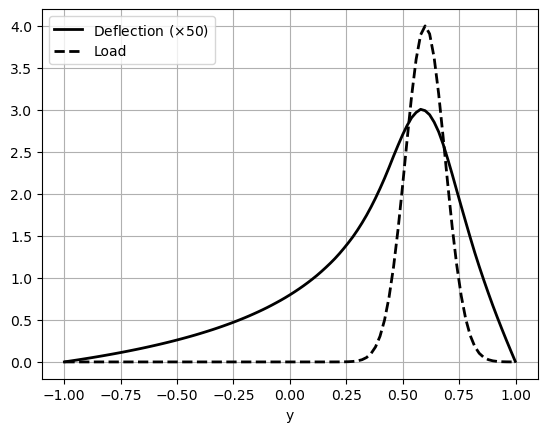

In [11]:
fig = plt.figure()
plt.plot(pts1[:, 1], 50 * u_values, "k", linewidth=2, label="Deflection ($\\times 50$)")
plt.plot(pts2[:, 1], p_values, "k--", linewidth=2, label="Load")
plt.grid(True)
plt.xlabel("y")
plt.legend()

Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Meshing 1D...
Info    : Meshing curve 1 (Ellipse)
Info    : Done meshing 1D (Wall 0.000127899s, CPU 0.000346s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.116577s, CPU 0.116359s)
Info    : 4201 nodes 8401 elements
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Meshing 1D...
Info    : Meshing curve 1 (Ellipse)
Info    : Done meshing 1D (Wall 0.000159038s, CPU 0.000197s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.115951s, CPU 0.116346s)
Info    : 4201 nodes 8401 elements
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Meshing 1D...
Info    : Meshing curve 1 (Ellipse)
Info    : Done meshing 1D (Wall 0.000132769s, CPU 0.000252s)
Info    : Meshing 2D...
Info   

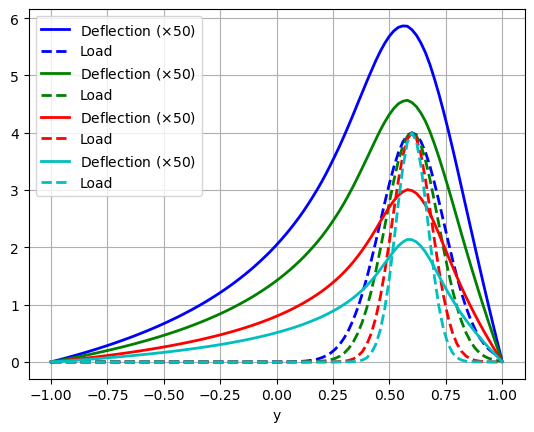

In [12]:
betas=[5,6,8,10]
colors=['b', 'g','r', 'c','k']
tol = 0.001  # Avoid hitting the outside of the domain
y = np.linspace(-1 + tol, 1 - tol, 101)
points = np.zeros((3, 101))
points[1] = y
fig = plt.figure()

def on_boundary(x):
    return np.isclose(np.sqrt(x[0]**2 + x[1]**2), 1)

for color, val in zip(colors,betas):
    job_beta = pr.create.job.Fenicsx("mem_{}".format(val))
    job_beta.create.domain.clear_gmsh()
    job_beta.geom = job_beta.create.geom.disk(0, 0, 0, 1, 1)
    job_beta.domain = job_beta.create.domain.standardDomain(job_beta.geom, 2, 0.03, 0.03)
    job_beta.mesh = job_beta.create.get_mesh(job_beta.domain)
    job_beta.V = job_beta.create.V.functionspace(job_beta.mesh, "Lagrange", 1)
    job_beta.appendBC(job_beta.make_dirichletBC_functionspace(job_beta.V, on_boundary, 0))
    x = job_beta.spatial_coord(job_beta.mesh)
    beta = job_beta.Constant_scalar(job_beta.mesh, val)
    R0 = job_beta.Constant_scalar(job_beta.mesh, 0.6)
    load = 4 * job_beta.Expression(-beta**2 * (x[0]**2 + (x[1] - R0)**2))
    job_beta.set_load(load)
    job_beta.solvePoisson()
    u_values, pts1 = job_beta.plot.getValues_deflection(job_beta.mesh, job_beta.uh, points)
    p_values, pts2 = job_beta.plot.getValues_pressure(job_beta.mesh, load, points)
    plt.plot(pts1[:, 1], 50 * u_values, color, linewidth=2, label="Deflection ($\\times 50$)")
    plt.plot(pts2[:, 1], p_values, color+"--", linewidth=2, label="Load")

plt.grid(True)
plt.xlabel("y")
plt.legend()